### Differential Privacy Methods Implementation:

#### Mechanism structure:

$$M(x)=f(x)+S(x)Z$$

where $f$ is a query, $S$ is a proportion factor and $Z$ is a random variable.

#### Mecanismos:

1. Laplace.
2. Gaussiano.
3. Uniforme.

#### Sensibilidades:

1. $\Delta f$: Sensibilidad global.
2. $S(f)$: Sensibilidad suave.
3. $L(f)$: Sensibilidad local.

#### Querys:

1. Mediana.

Por el momento, se implementarán los mecanismos de privacidad para el query $median(x)$, considerando el mécanismo clásico de Laplace, el mécanismo clásico Gaussiano con los diversos tipos de sensibilidad.




#### Diagrama de aplicación:

1. $M(x,f,\epsilon,\delta):
    1. $x$:
        * base de datos o histograma subconjunto de un dominio $D$.
    2. $f$:
        * query a evaluar sobre f.
        * sensibilidad de f:
            1. $l_1-sensitivity(D, f)$.
            2. $l_2-sensitivity(D, f)$.
            3. $LocalSensitivity(f, D, x)$.
            4. $SmoothSensitivity(D, f, \beta)$.
    3. $\epsilon$.
    4. $\delta$.


Consideremos el caso particular de el query $median( \cdot )$, probemos el mecanismo $M_{Lap}(\cdot)$, $M_{Gauss}(\cdot)$. Para el caso especial de bases de datos en el rango $[0,1]$.

1. $f$ : $meadian$, $D : [0, \Lambda]$, $l_1-sensitivity$ : $\Lambda$. $l_2-sensitivity$ : $\Lambda$.


        

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from math import erf

sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

In [3]:
def laplace_DP_noise(data: np.ndarray, query: callable, epsilon, query_sensitivity):
    scale = query_sensitivity/epsilon
    unif = np.random.rand()
    # Inverse transform sampling: 
    return query(data) - scale*np.sign(unif-0.5)*np.log(1-2*np.abs(unif-0.5)) 
    #return query(data) + np.random.laplace(scale=scale)

def gaussian_DP_noise(data: np.ndarray, query: callable, epsilon, delta, query_sensitivity):
    variance = (2*np.log(1.25/delta)*query_sensitivity**2)/epsilon**2
    # Box–Muller transform:
    return query(data) + np.sqrt(variance*-2*np.log(np.random.rand()))*np.cos(2*np.pi*np.random.rand())

In [48]:
def binary_search(func: callable, delta, start, end, tol=1.5E-5, max_iter=500):
    iteration = 0
    mid = (start+end)/2
    while (np.abs(func(mid)-delta)<tol and iteration<max_iter):
        if func(mid) > delta:
            end = mid
        else:
            start = mid
        mid = (start+end)/2
        iteration +=1
    return mid


def analytic_gaussian_DP_noise(data: np.ndarray, query: callable, epsilon, delta, query_sensitivity):
    guassian_CDF = lambda x: (1+erf(x/np.sqrt(2)))/2
    b_plus = lambda v: guassian_CDF(np.sqrt(v*epsilon))-np.exp(epsilon)*guassian_CDF(-np.sqrt(epsilon*(v+2)))
    b_minus = lambda v: guassian_CDF(-np.sqrt(v*epsilon))-np.exp(epsilon)*guassian_CDF(-np.sqrt(epsilon*(v+2)))

    delta_0 = b_plus(0)
    start=0
    end=1

    if delta >= delta_0:
        while b_plus(float(end))<=delta:
            start=end
            end=2*end
        v_sup = binary_search(b_plus, delta, start, end)
        alpha = np.sqrt(1+v_sup/2)-np.sqrt(v_sup/2)
    else:
        while b_minus(float(end))>=delta:
            start=end
            end=2*end
        v_inf = binary_search(b_plus, delta, start, end)
        alpha = np.sqrt(1+v_inf/2)+np.sqrt(v_inf/2)
    
    scale = alpha*query_sensitivity/np.sqrt(2*epsilon)

    return query(data) + scale*np.sqrt(-2*np.log(np.random.rand()))*np.cos(2*np.pi*np.random.rand())

<AxesSubplot:ylabel='Density'>

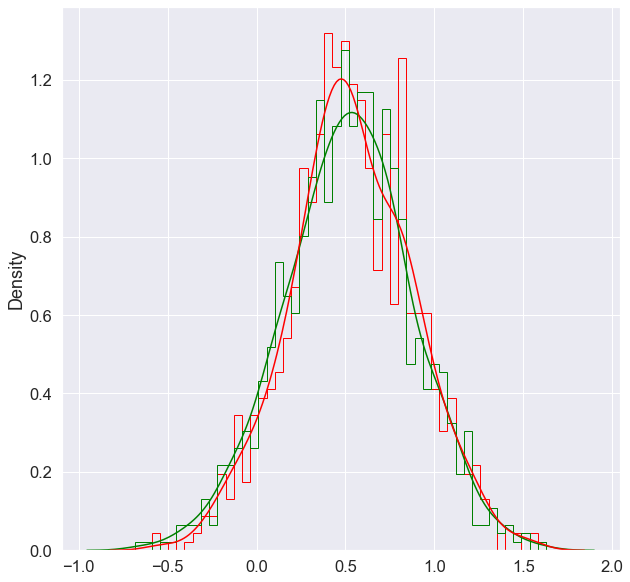

In [49]:
# Test data bases:

data_base = np.random.rand(50)
n_data_base = np.append(data_base, np.random.rand())
# Query attributes:

query_sensitivity = 1

# Mechanism attributes:

epsilon = 10
delta = 0.2

# Noisy results:

query_results = np.array([analytic_gaussian_DP_noise(data_base, np.median, epsilon, delta, 1) for i in range(1000)])
n_query_results = np.array([analytic_gaussian_DP_noise(n_data_base, np.median, epsilon, delta, 1) for i in range(1000)])

plt.figure(figsize=(10,10))
plt.hist([query_results, n_query_results], histtype='step', bins=50, density=True, color=["green","red"])
sns.kdeplot(query_results, color="green")
sns.kdeplot(n_query_results,color="red")

<AxesSubplot:ylabel='Density'>

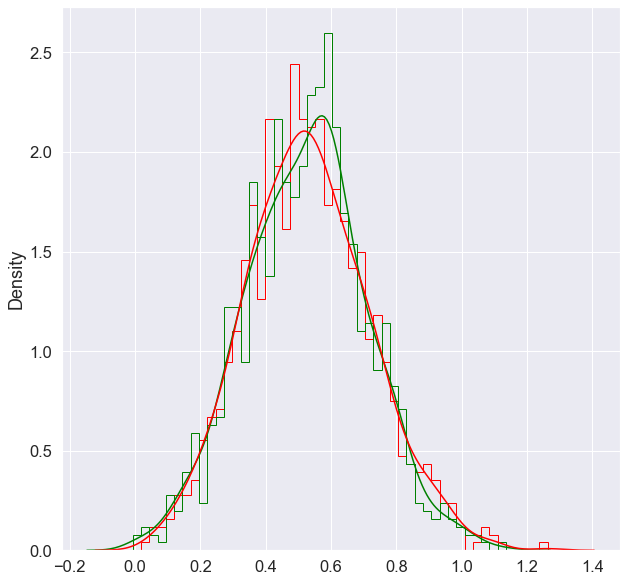

In [51]:
# Test data bases:

data_base = np.random.rand(50) 
n_data_base = np.append(data_base, np.random.rand())

# Query attributes:

query_sensitivity = 1

# Mechanism attributes:

epsilon = 10
delta = 0.2

# Noisy results:

query_results = np.array([gaussian_DP_noise(data_base, np.median, epsilon, delta, 1) for i in range(1000)])
n_query_results = np.array([gaussian_DP_noise(n_data_base, np.median, epsilon, delta, 1) for i in range(1000)])

plt.figure(figsize=(10,10))
plt.hist([query_results, n_query_results], histtype='step', bins=50, density=True, color=["green","red"])
sns.kdeplot(query_results, color="green")
sns.kdeplot(n_query_results,color="red")

<AxesSubplot:ylabel='Density'>

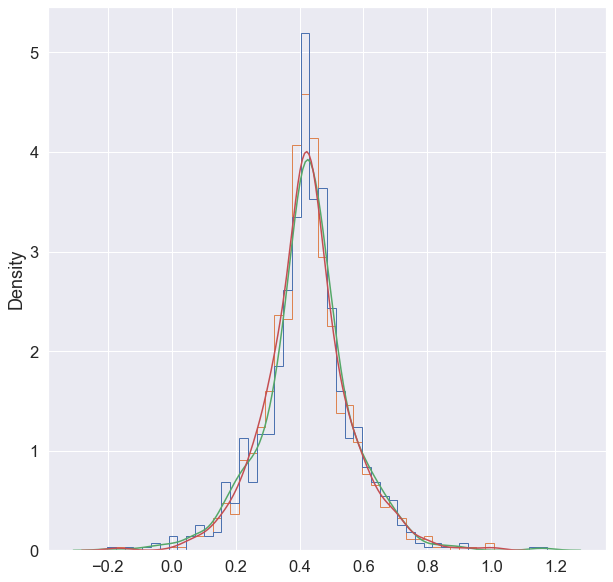

In [37]:
# Test data bases:

data_base = np.random.rand(100) 
n_data_base = np.append(data_base, np.random.rand())

# Query attributes:

query_sensitivity = 1

# Mechanism attributes:

epsilon = 10
delta = 0.00001

# Noisy results:

query_results = np.array([laplace_DP_noise(data_base, np.median, epsilon, 1) for i in range(1000)])
n_query_results = np.array([laplace_DP_noise(n_data_base, np.median, epsilon, 1) for i in range(1000)])

plt.figure(figsize=(10,10))
plt.hist([query_results, n_query_results], histtype='step', bins=50, density=True, )#color=["blueviolet","red"])
sns.kdeplot(query_results, ) #color="blueviolet")
sns.kdeplot(n_query_results, )#color="red")

In [49]:
# 150 query calls. 
data_base = np.random.rand(100)
n_data_base = np.append(data_base, np.random.rand())

query_results = np.array([laplace_DP_noise(data_base, np.median, 5, 1) for i in range(1000)])
n_query_results = np.array([laplace_DP_noise(n_data_base, np.median, 10, 1) for i in range(1000)])

In [5]:
np.argmax(np.abs(np.histogram(query_results, bins=50)[0]-np.histogram(n_query_results, bins=50)[0]))

28

In [58]:
np.e**0.1

1.1051709180756477

&lt;AxesSubplot:ylabel=&#39;Density&#39;&gt;

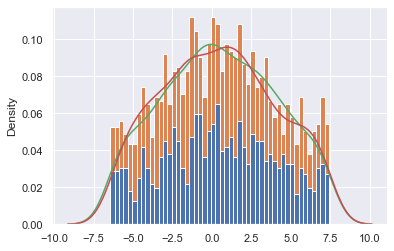

In [21]:
plt.hist([query_results, n_query_results], histtype='barstacked', bins=50, density=True)
sns.kdeplot(query_results)
sns.kdeplot(n_query_results)

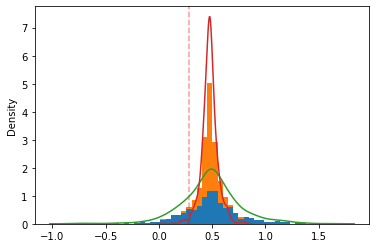

In [8]:
import numpy as np # for random data
import pandas as pd  # for convinience
import matplotlib.pyplot as plt  # for graphics
import seaborn as sns  # for nicer graphics

v1 = pd.Series(np.random.normal(0,10,1000), name='v1')
v2 = pd.Series(2*v1 + np.random.normal(60,15,1000), name='v2')

# plot a kernel density estimation over a stacked barchart
plt.figure()
plt.hist([query_results, n_query_results], histtype='barstacked', density=True, bins=50);
v3 = np.concatenate((query_results,n_query_results))

plt.axvline(0.27992968359445247, color="red", linestyle="dashed", alpha=0.4)
sns.kdeplot(query_results)
sns.kdeplot(n_query_results)
plt.show()

2.1177918191229272


&lt;matplotlib.lines.Line2D at 0x2572bf5b190&gt;

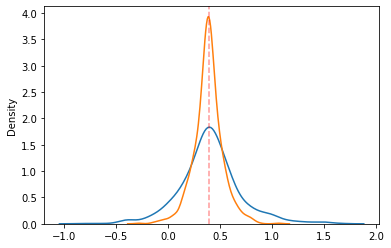

In [41]:
ax = sns.kdeplot(query_results)
sns.kdeplot(n_query_results)
r = np.argmax(np.abs(ax.lines[0].get_ydata()-ax.lines[1].get_ydata()))
print(np.max(np.abs(ax.lines[0].get_ydata()-ax.lines[1].get_ydata())))
plt.axvline(ax.lines[1].get_xdata()[r], color="red", linestyle="dashed", alpha=0.4)

In [31]:
ax.lines[1].get_ydata()

array([7.59748474e-05, 1.40989416e-04, 2.51470825e-04, 4.31226993e-04,
       7.11190842e-04, 1.12845757e-03, 1.72334860e-03, 2.53415865e-03,
       3.58977235e-03, 4.90106959e-03, 6.45279494e-03, 8.19807748e-03,
       1.00577790e-02, 1.19261526e-02, 1.36829456e-02, 1.52103586e-02,
       1.64116624e-02, 1.72273053e-02, 1.76444569e-02, 1.76972469e-02,
       1.74572259e-02, 1.70161944e-02, 1.64657150e-02, 1.58786426e-02,
       1.52974860e-02, 1.47324719e-02, 1.41694059e-02, 1.35846675e-02,
       1.29627659e-02, 1.23113519e-02, 1.16695003e-02, 1.11070754e-02,
       1.07154282e-02, 1.05918214e-02, 1.08213064e-02, 1.14600302e-02,
       1.25232571e-02, 1.39801154e-02, 1.57556746e-02, 1.77397803e-02,
       1.98012333e-02, 2.18053414e-02, 2.36324954e-02, 2.51952156e-02,
       2.64512269e-02, 2.74107031e-02, 2.81368542e-02, 2.87402308e-02,
       2.93680378e-02, 3.01900610e-02, 3.13825434e-02, 3.31109386e-02,
       3.55124691e-02, 3.86801092e-02, 4.26507089e-02, 4.74007270e-02,
      